# Mean-field:  The Hartree-Fock (HF) Approximation
## Honeycomb Latice Hubbard model

This notebook contains breif notes and several sample codes of the HF approximation for pedagogical purpose. The following text and codes are prepared by Mr.[Shibo Shan](https://quantummc.xyz/shibo-shan/), Mr.[Ting-Tung Wang](https://quantummc.xyz/members/ting-tung-wang/), Mr.[Menghan Song](https://quantummc.xyz/members/menghan-song/) and [ZYM](https://quantummc.xyz/members/ziyang-meng/).

In this notebook, we present both the self-consistent method and the gradient decend method for obtaining the ground state of the Hubbard model. One may want to review [HF for square lattice](https://colab.research.google.com/github/songmengh/mean-field/blob/main/HF_Hubbard_square.ipynb) for more details.

This note utilise the following useful references:
1. [Lechermann, Model Hamiltonians and Basic Techniques](https://www.researchgate.net/publication/299842893_Model_Hamiltonians_and_Basic_Techniques)
2. [M.Raczkowski et al., Phys. Rev. B. 101, 125103 (2020)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.101.125103)
3. [H.Feldner, Z.Y.Meng et al., Phys. Rev. B. 81, 115416 (2010)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.81.115416)
4. [Hirsch, Phys. Rev. B 31, 4403 (1985)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.31.4403)

### 1. Hubbard model: Honeycomb Lattice
#### 1.1 The tight-binding dispersion relation and gap equation
Considering the half-filling case, the Hamiltonian of the hubbard model reads,

$$
H=-t\mathop{\sum}\limits_{\langle i,j \rangle \sigma}c_{i\sigma}^\dagger c_{j\sigma}+h.c.+U\mathop{\sum}\limits_i (n_{i\uparrow}-\frac{1}{2})(n_{i\downarrow}-\frac{1}{2})=H_{band}+H_U  \ \ \  (U>0),
$$
where $\langle i,j \rangle$ denotes the nearest neighbour hopping on the honeycomb(HC) lattice.

The figure below shows the honeycomb lattice and its first Brillouin zone.

<p align="center">
<img src="https://github.com/songmengh/mean-field/blob/main/figures/HC_lattice.png?raw=1" width=350/>
<img src="https://github.com/songmengh/mean-field/blob/main/figures/HC_BZ.png?raw=1" width=320/>
</p>

Here, one site has three nearest neighbours, compared with four on the square lattice. $\quad \mathbf{a_1}=(\frac{\sqrt{3}}{2},\frac{1}{2})$ , $\mathbf{a_2}=(\frac{\sqrt{3}}{2},-\frac{1}{2})$ are the two primitive vectors. $\quad\mathbf{b_1}=\frac{4\pi}{\sqrt{3}}(\frac{1}{2},\frac{\sqrt{3}}{2})$, $\mathbf{b_2}=\frac{4\pi}{\sqrt{3}}(\frac{1}{2},-\frac{\sqrt{3}}{2})$ are the two reciprocal lattice vectors.

We will first calculate the $H_{band}$ term, which is to solve the tight-binding relation of HC lattice. We use $a^{\dagger}_{i\pm \tau_{j}}$ and $a_{i\pm \tau_{j}}$ to represent the creation and annihilation of an electron at site A in the cell located at $\mathbf{r_i}\pm \mathbf{a_j}$ . Similarly, $b_{i\pm \tau_{j}}^\dagger$ and $b_{i\pm \tau_{j}}$ represent the creation and annihilation of an electron at site B in the cell located at $\mathbf{r_i} \pm \mathbf{a_j}$. Dropping the spin index, the $H_{band}$ term becomes

$$
H_{band}=-t\sum_ia_i^\dagger(b_{i}+b_{i-\tau_1}+b_{i-\tau_2})+h.c.
$$

We assume that there are N cells, namely 2N sites. Applying Fourier transform to $a_i$ $a_i^\dagger$ (and similarly for $b_i\;b_i^\dagger$)
$$
a_i = \sqrt{\frac{1}{N}}\sum_\mathbf{k}e^{i\mathbf{k}\cdot\mathbf{r_i}}a_{\mathbf{k}},\quad
a_i^\dagger = \sqrt{\frac{1}{N}}\sum_\mathbf{k}e^{-i\mathbf{k}\cdot\mathbf{r_i}}a_\mathbf{k}^\dagger
$$

and using the relation

$$
\sum_ie^{i\mathbf{r_i}\cdot(\mathbf{k_1}-\mathbf{k_2})}=N\delta_{\mathbf{k_1},\mathbf{k_2}}
$$
we obtain

\begin{aligned}
H_{band} &= -t\sum_{\mathbf{k}}a_{\mathbf{k}}^\dagger b_{\mathbf{k}}(1+e^{-i\mathbf{k}\cdot\mathbf{a_1}}+e^{-i\mathbf{k}\cdot\mathbf{a_2}})+h.c.\\
&=
\sum_{\mathbf{k}}
\begin{pmatrix}
a_{\mathbf{k}}^\dagger & b_{\mathbf{k}}^\dagger
\end{pmatrix}
\begin{pmatrix}
0&-t(1+e^{-i\mathbf{k}\cdot\mathbf{a_1}}+e^{-i\mathbf{k}\cdot\mathbf{a_2}})\\
-t(1+e^{i\mathbf{k}\cdot\mathbf{a_1}}+e^{i\mathbf{k}\cdot\mathbf{a_2}})&0
\end{pmatrix}
\begin{pmatrix}
a_{\mathbf{k}}\\
b_{\mathbf{k}}
\end{pmatrix}
\end{aligned}

Solve the eigenvalues, we obtain the tight-binding dispersion relation
$$
\epsilon(\mathbf{k})=\pm t\sqrt{3+2 \cos  k_y+4 \cos \left(\frac{\sqrt{3}}{2}k_x\right) \cos \left(\frac{1}{2}k_y \right)}
$$
It's plotted below.

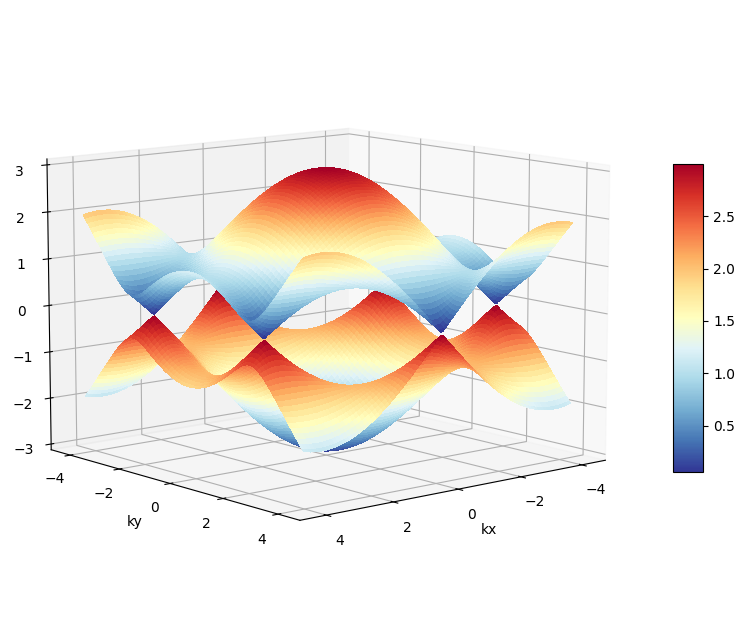

In [ ]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

sqrt = np.sqrt
cos = np.cos


d = np.sqrt(3)
t1 = 1
t3 = 0

fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(111, projection='3d')

# x = np.arange(-2.0*np.pi, 2.0*np.pi, 0.05)
# y = np.arange(-2.0*np.pi, 2.0*np.pi, 0.05)

x = np.arange(-4.0*np.pi/3, 4.0*np.pi/3, 0.05)
y = np.arange(-4.0*np.pi/3, 4.0*np.pi/3, 0.05)
x, y = np.meshgrid(x, y)

f = sqrt(
    t1*t1*(3.0 + 2.0*cos(y) + 4.0*cos(d/2.0*x)*cos(0.5*y))
    + t3*t3*(3.0 + 2.0*cos(2.0*d*x) + 4.0*cos(d*x)*cos(3.0*y))
    + t1*t3*(2.0*cos(3.0*y) + 4.0*cos(d*x) + 8.0*cos(d/2.0*x)*cos(1.5*y)
             + 4.0*cos(1.5*d*x)*cos(1.5*y))
)


surf1 = ax.plot_surface(
    x, y,  f,
    rstride=2, cstride=2,
    cmap=cm.RdYlBu_r,
    linewidth=0.1, antialiased=False
)

surf2 = ax.plot_surface(
    x, y, -f,
    rstride=2, cstride=2,
    cmap=cm.RdYlBu_r,
    linewidth=0.1, antialiased=False
)
ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.view_init(elev=10, azim=50)
fig.colorbar(surf1, shrink=0.5, aspect=10)

plt.show()

Now calculate the $H_U$ term. Applying the mean-field approximation yields
$$
H_U = U\sum_{i}^{} n_{i\uparrow}n_{i\downarrow}=U\sum_{i}^{}(n_{i\uparrow} \left \langle  n_{i\downarrow}\right \rangle+n_{i\downarrow} \left \langle  n_{i\uparrow}\right \rangle-\left \langle n_{i\uparrow} \right \rangle \left \langle  n_{i\downarrow}\right \rangle).
$$

Still, for the antiferromagnetic ordering and half-filling condition, we assume that
$$
\langle n_{iA\sigma}\rangle=\frac{1}{2}+\sigma m \; , \quad \langle n_{iB\sigma}\rangle=\frac{1}{2}-\sigma m
$$

Applying Fourier transform, the first two terms are

\begin{align*}
U\sum_{i\sigma}n_{i\sigma} \langle n_{i\bar{\sigma}}\rangle
&=U\sum_{i\sigma}(n_{iA\sigma}(\frac{1}{2}+\sigma m)+n_{iB\sigma}(\frac{1}{2}-\sigma m))\\
&=NU+U\sum_{\mathbf{k}\sigma}(a_{\mathbf{k}\sigma}^\dagger a_{\mathbf{k}\sigma}\;\sigma m-b_{\mathbf{k}\sigma}^\dagger b_{\mathbf{k}\sigma}\;\sigma m)
\end{align*}

Dropping the constant term, the full hamiltonian is

\begin{aligned}
H &= H_{band}+H_U\\
&=\sum_{\mathbf{k}\sigma}
\begin{pmatrix}
a_{\mathbf{k}\sigma}^\dagger& b_{\mathbf{k}\sigma}^\dagger
\end{pmatrix}
\begin{pmatrix}
U\sigma m&-t(1+e^{-i\mathbf{k}\cdot\mathbf{a_1}}+e^{-i\mathbf{k}\cdot\mathbf{a_2}})\\
-t(1+e^{i\mathbf{k}\cdot\mathbf{a_1}}+e^{i\mathbf{k}\cdot\mathbf{a_2}})&-U
\sigma m
\end{pmatrix}
\begin{pmatrix}
a_{\mathbf{k}\sigma}\\
b_{\mathbf{k}\sigma}
\end{pmatrix}
\end{aligned}


Solve the eigenvalues, we have two bands

$$
\lambda^{\pm}(\mathbf{k})=\pm\sqrt{\epsilon(\mathbf{k})^2+U^2m^2}=\pm\sqrt{\epsilon(\mathbf{k})^2+\Delta^2}
$$

At the Dirac points $K$, we have $\epsilon(K)=0$ , which leads to an energy gap $2\Delta$ . Thus a finite staggered magnetization leads to the opening of a mass gap in the spectrum.   

At half-filling condition(2N electrons), the ground state energy is achieved by making all the 2N electrons occupy the lower band.

Adding back the constant term

$$
\begin{aligned}
-U\sum_i\langle n_{i\uparrow}\rangle\langle n_{i\downarrow}\rangle&=-U\sum_i(\langle n_{iA\uparrow}\rangle\langle n_{iA\downarrow}\rangle + \langle n_{iB\uparrow}\rangle\langle n_{iB\downarrow}\rangle)\\
&=-2U\sum_i(\frac{1}{2}+\sigma m)(\frac{1}{2}-\sigma m)\\
&=-\frac{NU}{2}+2NUm^2
\end{aligned}
$$

we obtain the ground state energy per electron and its $Gradient$ with respect to m

$$
\begin{aligned}
E = \frac{E_g}{2N}
&= \frac{1}{2N}\Bigl(-\frac{N U}{2} + 2 N U m^2
   - 2 \sum_{\mathbf{k}\in BZ}
     \sqrt{\epsilon(\mathbf{k})^2 + U^2 m^2}\Bigr)\\
&= -\frac{U}{4} + U m^2
   - \frac{1}{N} \sum_{\mathbf{k}\in BZ}
     \sqrt{\epsilon(\mathbf{k})^2 + U^2 m^2}\,.
\end{aligned}
$$

$$
\frac{\partial E}{\partial m} = 2Um-\frac{1}{N}\sum_{\mathbf{k}\in BZ}\frac{U^2m}{\sqrt{\epsilon(\mathbf{k})^2+U^2m^2}}
$$

The abbreviation BZ is the first Brillouin zone. There are N k points in the first Brillouin zone. Requiring that E(m) be minimum yields the gap equation

$$
1=\frac{1}{2N}\sum_{\mathbf{k}\in BZ}\frac{U}{\sqrt{\epsilon(\mathbf{k})^2+\Delta^2}}=\frac{U}{2N}\int_{-3t}^0\frac{\rho(\epsilon)d\epsilon}{\sqrt{{\epsilon^2}+\Delta^2}}
$$

where $\Delta=Um$, the density of states $\rho(\epsilon)$ satisfies $\int_{-3t}^0\rho(\epsilon)=N$. At critical point, the gap vanishes, which yields

$$
1=\frac{U_{cr}}{2N}\sum_{\mathbf{k}\in BZ}\frac{1}{|\epsilon(\mathbf{k})|}
$$

$$
U_{cr}=\left(\frac{1}{2N}\sum_{\mathbf{k}\in BZ}\frac{1}{\epsilon(\mathbf{k})}\right)^{-1}
$$

This can be numerically solved. The code is shown below.

In [ ]:
L = 1000
e0 = np.zeros((L,L))
a1 = np.array([np.sqrt(3)/2,1/2])
a2 = np.array([np.sqrt(3)/2,-1/2])
b1 = np.array([1/2,np.sqrt(3)/2])*4*np.pi/np.sqrt(3)
b2 = np.array([1/2,-np.sqrt(3)/2])*4*np.pi/np.sqrt(3)
Uc = 0
for kx_point in range(L):
    for ky_point in range(L):
        k = kx_point/L*b1+ky_point/L*b2
#        e0[kx_point,ky_point] = abs(1+np.exp(-1j*np.dot(k,a1))+np.exp(-1j*np.dot(k,a2)))
        e0[kx_point,ky_point] = np.sqrt(3+2*np.cos(k[1])+4*np.cos(np.sqrt(3)/2*k[0])*np.cos(0.5*k[1]))
e0 = e0[e0 != 0]
Ucr = 1/(np.sum(1/e0)/L**2/2)
print(f'the value of Ucr is {Ucr:.3f} t')

the value of Ucr is 2.232 t


The summation range in the code is the rhombus enclosed by $b_1$ and $b_2$ rather than the first Brillouin zone, but it's the same because of the translational invariance in reciprocal space. As shown above, $U_{cr}=2.23t$. For $U>U_{cr}$, the value of m is determined by the gap equation. We will solve the equation by the Gradient-descent algorithm.

### 1.2 The instability criterion

We can derive the same $U_{cr}$ from the instability criterion. Recall that the generalized susceptibility is

$$
\chi(\mathbf{q})\sim\frac{\chi^{(0)}(\mathbf{q})}{1-U\chi^{(0)}(\mathbf{q})}
$$

where
$$
\chi^{(0)}(\mathbf{q})=-\frac{1}{2N}\sum_{\mathbf{p}\in BZ}\frac{f(\epsilon_{\mathbf{p}}) - f(\epsilon_{\mathbf{p+q}})}{\epsilon_{\mathbf{p}} - \epsilon_{\mathbf{p+q}}}
$$

$
f(\epsilon)=\frac{1}{e^{\beta(\epsilon-\epsilon_F)}+1}
$
is the fermi distribution function.
The sum splits into four contributions, corresponding to whether $\epsilon_\mathbf{p}$ and $\epsilon_{\mathbf{p+q}}$ lie in the same band or in different bands.

In the case where they lie in the same band (as $\mathbf{q}\to\mathbf{0}$), one finds

$$
-\frac{1}{2N}\sum_{\mathbf{p}\in BZ}\frac{f(\epsilon_{\mathbf{p}}) - f(\epsilon_{\mathbf{p+q}})}{\epsilon_{\mathbf{p}} - \epsilon_{\mathbf{p+q}}} = -\frac{1}{2N}\sum_{\mathbf{p}}\frac{\frac{\partial f}{\partial \epsilon}(\frac{\partial \epsilon}{\partial \mathbf{p}}\cdot\mathbf{q})}{\frac{\partial \epsilon}{\partial \mathbf{p}}\cdot\mathbf{q}}=-\frac{1}{2N}\int_{-3t}^0 \frac{\partial f}{\partial\epsilon}\rho(\epsilon) d\epsilon
$$

where density of states $\rho(\epsilon)$ satisfies $\int_{-3t}^0\rho(\epsilon)=N$. The density of states per particle is plotted below.

<p align="center">
<img src="https://github.com/songmengh/mean-field/blob/main/figures/dos_HC.png?raw=1" width=400/>
</p>

When $T\to 0K$, $f(\epsilon)$ behaves as a step function

$$
f(\epsilon)=\frac{1}{e^{\beta(\epsilon-\epsilon_F)}+1}=-\Theta(\epsilon-\epsilon_F)
$$
$$
\frac{\partial f}{\partial \epsilon}=-\delta(\epsilon-\epsilon_F)
$$

Then we have

$$
-\frac{1}{2N}\sum_{\mathbf{p}\in BZ}\frac{f(\epsilon_{\mathbf{p}}) - f(\epsilon_{\mathbf{p+q}})}{\epsilon_{\mathbf{p}} - \epsilon_{\mathbf{p+q}}} =\frac{1}{2N}\rho(\epsilon_F)=\frac{1}{2N}\rho(0)=0
$$

where $\epsilon_F=0$ at half-filling condition.

In the case where $\epsilon_\mathbf{p}$ and $\epsilon_{\mathbf{p+q}}$ belong to different bands while $\epsilon_{\mathbf{p}}>\epsilon_\mathbf{p+q}, \mathbf{q}\to \mathbf{0}$, we have

$$
-\frac{1}{2N}\sum_{\mathbf{p}\in BZ}\frac{f(\epsilon_{\mathbf{p}}) - f(\epsilon_{\mathbf{p+q}})}{\epsilon_{\mathbf{p}} - \epsilon_{\mathbf{p+q}}} = -\frac{1}{2N}\sum_{\mathbf{p}\in BZ}\frac{-1-0}{\epsilon_\mathbf{p}-(-\epsilon_\mathbf{p})}=\frac{1}{4N}\sum_{\mathbf{p}\in BZ}\frac{1}{\epsilon_\mathbf{p}}
$$

For $\epsilon_{\mathbf{p}}<\epsilon_\mathbf{p+q}, \mathbf{q}\to \mathbf{0}$, we recover the same result. Therefore
$$
\chi^{(0)}(\mathbf{q}\to \mathbf{0}) = 0+2\frac{1}{4N}\sum_{\mathbf{p}\in BZ}\frac{1}{|\epsilon_\mathbf{p}|}=\frac{1}{2N}\sum_{\mathbf{p}\in BZ}\frac{1}{|\epsilon_\mathbf{p}|}
$$

It is easy to prove that the $\chi^{(0)}(\mathbf{q})$ achieves its maximum when $\mathbf{q}\to \mathbf{0}$. Thus

$$
U_{cr} = \frac{1}{\chi^{(0)}(\mathbf{q}\to \mathbf{0})}=\Big(\frac{1}{2N}\sum_{\mathbf{p}\in BZ}\frac{1}{|\epsilon_\mathbf{p}|}\Big)^{-1}
$$

$U_{cr}$ agrees with gap equation result.

For the square lattice at half-filling, the perfect nesting makes $\chi^{(0)}(\pi,\pi)$ diverge, hence $U_{cr}=0$, the system is in antiferromagnetic phase for any finite $U$. By contrast, while the honeycomb lattice is also bipartite, the half-filled Hubbard model on this lattice is distinguished by a vanishing density of states at the Fermi level, such that $\chi^{(0)}(\mathbf{0})$ is finite, $U_{cr}$ is finite, resulting in the stable Dirac semimetal phase at $U=0$. A relative large $U_{cr}$ is required to drive the system into the antiferromagnetic insulator phase. One should notice a phase transition between the paramagnetic semimetal and the antiferromagnetic insulator. The mean-field code below, captures this transition.

### 1.3 Analytical solution

At Dirac point $K=(\frac{2\pi}{\sqrt{3}},\pm\frac{2\pi}{3})$,
the dispersion relation is linearized, allowing an analytical solution. At the vicinity of K point, set

$$
k_x = \frac{2\pi}{\sqrt{3}}+k_x^\prime, \quad k_y = \frac{2\pi}{3}+k_y^\prime
$$

and use the relation $\cos(x)\overset{x\to0}{\approx}1-\frac{x^2}{2}$, we obtain

$$
\epsilon(\mathbf{k}^\prime)=\pm\frac{\sqrt{3}}{2}t|\mathbf{k}^\prime| = \pm\frac{\sqrt{3}}{2}tk^\prime
$$

For this dispersion relation, the density of states $\rho(\epsilon)$ satisfies

$$
\rho(\epsilon)d\epsilon = 2\pi k^\prime dk^\prime \cdot \frac{\sqrt{3}N}{8\pi^2} \cdot 2

$$

The factor $\frac{\sqrt{3}N}{8\pi^2}$ is the k points density in reciprocal space. The factor 2 comes from that there are 2 dirac cones in the first Brillouin zone. We obtain

$$
\rho(\epsilon) = \frac{2\sqrt{3} N}{3\pi t^2}\epsilon
$$

We introduce a high-energy cutoff $\Lambda$ to ensure that

$$
\int_0^\Lambda\rho(\epsilon)d\epsilon = N
$$

which yields $\Lambda = \sqrt{\sqrt{3}\,\pi}t$. The gap equation becomes

$$
1 = \frac{U}{2N}\int_{0}^\Lambda\frac{\rho(\epsilon)d\epsilon}{\sqrt{{\epsilon^2}+\Delta^2}}
=\frac{U}{\sqrt{3}\,\pi t^2}(\sqrt{\Lambda^2+\Delta^2}-\Delta)
$$

At critical point, $\Delta=0$ which leads to

$$
\Lambda = \sqrt{\sqrt{3}\,\pi}t\approx 2.332t
$$

The result is very close to the numerical result 2.232t.
substituting $\Lambda$ back into the gap equation, We obtain

$$
m = \frac{1}{2}(1-\frac{U_{cr}^2}{U^2})
$$

such that in the vicinity of critical point,

$$
m \propto(U-U_{cr})^\beta
$$
with order parameter $\beta =1$.


### 2. Code

#### 2.1 Self-consistent

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [ ]:
def cart_coord(i,Lx): # i is the site index starts from 1.
    ix = i % Lx
    iy = i//Lx + 1
    if i % Lx == 0:
        iy -= 1
        ix = Lx
    return ix,iy

def linear_index(ix,iy,Lx):  #output linear index starts from 1.
    return int((iy-1)*Lx+ix)

def MakeSublattice(Lx,Ly):
    N_pc=Lx*Ly
    sub_A=np.zeros(int(N_pc/2))
    sub_B=np.zeros(int(N_pc/2))
    sub_indexa=0
    sub_indexb=0
    for subix in range(Lx):
        for subiy in range(Ly):
            if np.mod(subix+subiy+1,2)==0:
                sub_A[sub_indexa]=subix+subiy*Ly
                sub_indexa=sub_indexa+1
            else:
                sub_B[sub_indexb]=subix+subiy*Ly
                sub_indexb=sub_indexb+1
    return sub_A, sub_B

def Neighbor(index,Lx,Ly):
    ix,iy=cart_coord(index,Lx)
    up_y = iy - 1     # Here we denote ⬇ as the 'up' direction for y coordinate.
    if up_y <1:
        up_y=Ly
    up = linear_index(ix,up_y,Lx)

    down_y = iy+1
    if down_y > Ly:
        down_y = 1
    down=linear_index(ix,down_y,Lx)

    left_x=ix-1
    if left_x < 1:
        left_x = Lx
    left = linear_index(left_x,iy,Lx)

    right_x = ix+1
    if right_x > Lx:
        right_x = 1
    right = linear_index(right_x,iy,Lx)
    return up,down,left,right

def gen_auxf(MatDim,N_time_slice):
    auxf = np.zeros((MatDim,N_time_slice),dtype=int)
    for i in range(MatDim):
        for j in range(N_time_slice):
            auxf[i][j]= int(2*int(2*np.random.random())-1)
    return auxf

def GetK(Lx,Ly,t):
    MatDim = Lx*Ly
    N_pc = Lx*Ly
    sub_A, sub_B = MakeSublattice(Lx,Ly)
    K_mat = np.zeros((MatDim,MatDim))
    for i in range(N_pc):
        down = Neighbor(i+1,Lx,Ly)[1]-1
        if i in sub_A:
            left = Neighbor(i+1,Lx,Ly)[2]-1
            K_mat[i][down]-=t
            K_mat[down][i]-=t
            K_mat[i][left]-=t
            K_mat[left][i]-=t
        elif i in sub_B:
            right = Neighbor(i+1,Lx,Ly)[3]-1
            K_mat[i][down]-=t
            K_mat[down][i]-=t
            #K_mat[i][right]-=t
            #K_mat[right][i]-=t
    return K_mat


In [ ]:
def GetHup(Lx,Ly,nup,ndn,K,U):
    N = Lx*Ly
    Diag = np.diag(ndn)*U
    Hup = np.zeros((N,N))
    Hup += K
    Hup += Diag
    #Hup -= 1/2*U*sum(nup*ndn)
    return Hup

In [ ]:
def GetHdn(Lx,Ly,nup,ndn,K,U):
    N = Lx*Ly
    Diag = np.diag(nup)*U
    Hdn = np.zeros((N,N))
    Hdn += K
    Hdn += Diag
    #Hdn -= 1/2*U*sum(nup*ndn)
    return Hdn

In [ ]:
def GetEigen(H):
    eig_value=np.real(np.linalg.eig(H)[0])
    eig_vec=eig_vec=np.real(np.linalg.eig(H)[1])
    idx_sorted1 = np.argsort(eig_value)
    eig_value=eig_value[idx_sorted1]
    eig_vec=eig_vec[:,idx_sorted1]
    return eig_value,eig_vec

In [ ]:
def Getnup(upvecs,N):
    nup = np.zeros((N))
    for i in range(N):
        value = 0
        for j in range(N//2):
            value += upvecs[i][j]**2
        nup[i] = value
    return nup

In [ ]:
def Getndn(dnvecs,N):
    ndn = np.zeros((N))
    for i in range(N):
        value = 0
        for j in range(N//2):
            value += dnvecs[i][j]**2
        ndn[i] = value
    return ndn

In [ ]:
def Iteration(Lx,Ly,U):

    N = Lx*Ly
    t = 1
    K = GetK(Lx,Ly,t)
    delt = 0.0001
    alpha = 0.6
    times=0

    #initial n
    nup = np.random.random((N))
    ndn = np.random.random((N))

    E1=E2=0
    while True:
        Hup = GetHup(Lx,Ly,nup,ndn,K,U)
        Hdn = GetHdn(Lx,Ly,nup,ndn,K,U)
        eig_eup,eig_vup = GetEigen(Hup)
        eig_edn,eig_vdn = GetEigen(Hdn)

        Eup = sum(eig_eup[:(N//2)])
        Edn = sum(eig_edn[:(N//2)])
        E = Eup+Edn

        E1 = E2
        E2 = E

        nup0 = nup
        ndn0 = ndn

        nup1 = Getnup(eig_vup,N)
        ndn1 = Getndn(eig_vdn,N)

        nup_new = (1-alpha)*nup0+alpha*nup1
        ndn_new = (1-alpha)*ndn0+alpha*ndn1

        diffE = abs(E2-E1)
        diffup = abs(sum((nup_new-nup0)))
        diffdn = abs(sum((ndn_new-ndn0)))

        nup = nup_new
        ndn = ndn_new

        if diffup < delt**2 and diffdn < delt**2 and diffE<0.0001:
            break

        times+=1
    return nup,ndn,E

In [ ]:
def Run(Lx,Ly,U):
    N = Lx*Ly
    nitr = 50
    nups = np.zeros((nitr,N))
    ndns = np.zeros((nitr,N))
    Es = np.zeros((nitr))
    for i in range(nitr):

        nup,ndn,E = Iteration(Lx,Ly,U)
        nups[i]=nup
        ndns[i]=ndn
        Es[i]=E
        #print(E)
    idx = np.argmin(Es)
    nup_gs = nups[idx]
    ndn_gs = ndns[idx]
    E_gs = Es[idx]

    return nup_gs,ndn_gs,E_gs

In [ ]:
U_lst = np.arange(0.01,5,0.2)
m_lst = []
for i in range(len(U_lst)):
    if i%10==0:
        print(i)
    U = U_lst[i]
    nup,ndn,E = Run(6,6,U)
    m = abs(nup[0]-ndn[0])/2
    m_lst.append(m)

0
10
20


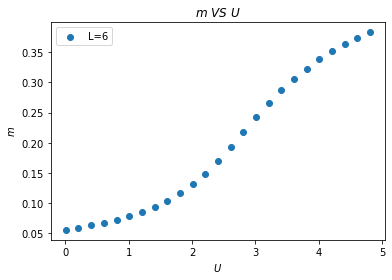

In [ ]:
plt.scatter(U_lst,m_lst,label='L=6')
plt.title(r'$m\ VS\ U$')
plt.xlabel(r'$U$')
plt.ylabel(r'$m$')
plt.legend()

#### 2.2 Gradient-descent algorithm

In [2]:
def getdedm(U,Ne,e0,m):
    '''
    return the derivative dE/dm for gradient descend
    '''
    dedm = -2*(U**2)*m*(1/np.sqrt((m**2)*(U**2)+e0)).sum()/Ne + 2*U*m
    return dedm

def gete(U,Ne,e0,m):
    '''
    get energy
    '''
    e = -2*(np.sqrt((m**2)*(U**2)+e0)).sum()/Ne+U/2+U*m**2
    return e

In [3]:
Ulist = np.arange(0.1,5,0.1)
Llist = [30,60,90,120,150]
alpha=0.1

e_end = np.inf*np.ones((len(Llist),len(Ulist)))
m_end = np.zeros((len(Llist),len(Ulist)))
itr_end = np.zeros((len(Llist),len(Ulist)))

for i in range(len(Llist)):
    L = Llist[i]
    Ne=2*L**2
    e0 = np.zeros((L,L))
    for kx_point in range(L):
        for ky_point in range(L):
            k=kx_point*np.array([1/2,np.sqrt(3)/2])+ky_point*np.array([1/2,-np.sqrt(3)/2])/L*2*np.pi/np.sqrt(3)*2 #generate k vectors
            dot1 = np.dot(k,np.array([np.sqrt(3)/2,1/2]))
            dot2 = np.dot(k,np.array([np.sqrt(3)/2,-1/2]))
            e0[kx_point,ky_point]=abs(1+np.exp(-1j*dot1*2*np.pi)+np.exp(-1j*dot2))**2
    m=0
    for j in range(len(Ulist)):
        U = Ulist[j]
        m+=0.0005*np.random.random()
        error=1
        itr=0
        while abs(error)>10**-8:
            error = alpha*getdedm(U,Ne,e0,m)
            m -= error
            itr += 1
        e_end[i,j] = gete(U,Ne,e0,m)
        m_end[i,j] = abs(m)
        itr_end[i,j] = itr




Here a random perturbation is added to m before it enters next round of iteration.  This allows us to use the convergent result from the last $U$ to speed up the convergence, and at the same time eliminates the posibility of getting a local maximum instead of minimum.

Plot the result.

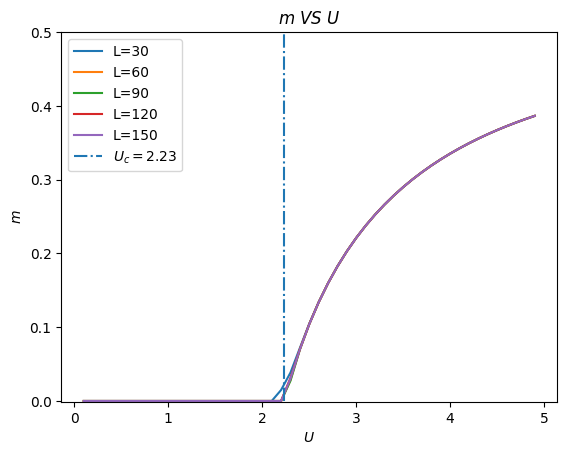

Text(0, 0.5, '$m$')

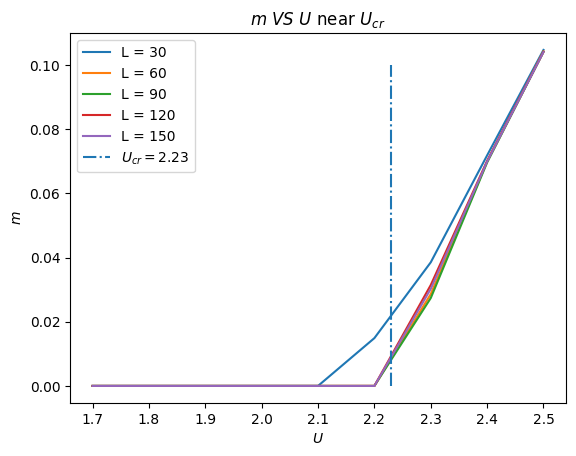

In [21]:
plt.plot(Ulist,m_end[0])
plt.plot(Ulist,m_end[1])
plt.plot(Ulist,m_end[2])
plt.plot(Ulist,m_end[3])
plt.plot(Ulist,m_end[4])


plt.vlines(2.23,0,0.5,linestyles='-.')
plt.ylim(-0.001,0.5)
#plt.xlim(0.1,1)
le_here=['L='+str(L) for L in Llist]+['$U_c=2.23$']
plt.legend(le_here)
plt.title('$m\ VS\  U$')
plt.xlabel('$U$')
plt.ylabel('$m$')
plt.show()


Ulist_ = Ulist[(Ulist > 1.6) & (Ulist < 2.6)]
for i in range(len(Llist)):
    m_ = m_end[i,(Ulist > 1.6) & (Ulist < 2.6)]
    plt.plot(Ulist_,m_, label=f'L = {Llist[i]}')
    plt.title(r'$m\ VS\ U$ near $U_{cr}$')
plt.vlines(2.23,0,0.1,linestyles='-.',label=r'$U_{cr}=2.23$')
plt.legend()

plt.xlabel(r'$U$')
plt.ylabel(r'$m$')

Plot the Gradient-descent result and the analytical result

$$
m = \frac{1}{2}(1-\frac{U_{cr}^2}{U^2})
$$
where $U_{cr}=\sqrt{\sqrt{3}\,\pi}\,t$. Two results align well.

In [28]:
Y = []
Uc = np.sqrt(np.sqrt(3)*np.pi)
X = np.arange(1,5,0.05)

for ix in X:
  if ix<Uc:
    Y.append(0)
  else:
    y = 0.5*(1-Uc**2/ix**2)
    Y.append(y)

2.332680452334321


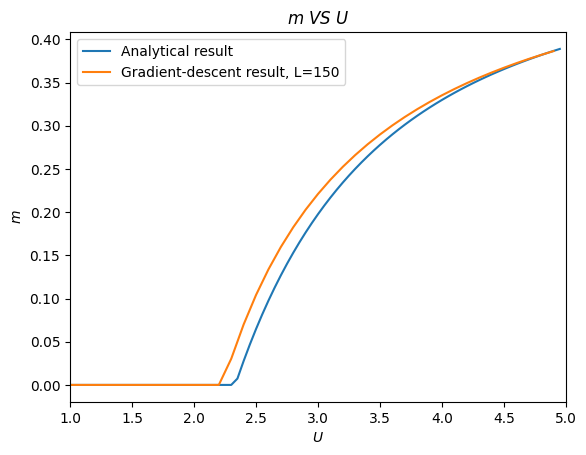

In [29]:
plt.plot(X,Y,label='Analytical result')
plt.plot(Ulist,m_end[4],label='Gradient-descent result, L=150')
plt.title('$m\ VS\  U$')
plt.xlabel('$U$')
plt.ylabel('$m$')
plt.xlim(1,5)
plt.legend()
print(Uc)

Here we can also check the criticle exponents $\beta$ for the gap, $\Delta$. Near $U_c$, the scaling behavior is:

$$
\Delta = Um_s \sim (U-U_c)^{\beta}.
$$

Our results suggests that $\beta = 1$.

In [ ]:
delta_end = np.zeros((len(Llist),len(Ulist)))
delta_end[:] = m_end[:]
for i in range(delta_end.shape[0]):
    delta_end[i] = delta_end[i]*Ulist

Text(0, 0.5, '$\\Delta$')

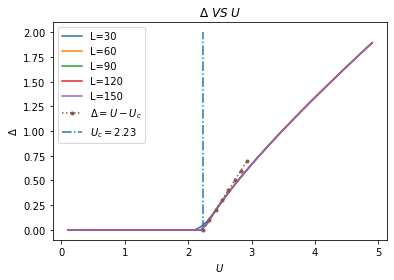

In [ ]:
plt.plot(Ulist,delta_end[0])
plt.plot(Ulist,delta_end[1])
plt.plot(Ulist,delta_end[2])
plt.plot(Ulist,delta_end[3])
plt.plot(Ulist,delta_end[4])
plt.vlines(2.23,0,2,linestyles='-.')

X_lst = np.arange(2.23,3,0.1)
Y_lst = []
for ix in X_lst:
    y = ix-2.23
    Y_lst.append(y)
plt.plot(X_lst,Y_lst,marker='.',linestyle=':')
#plt.ylim(-0.001,0.5)
#plt.xlim(0.1,1)
le_here=['L='+str(L) for L in Llist]+['$\Delta=U-U_c$']+['$U_c=2.23$']
plt.legend(le_here)
plt.title('$\Delta \ VS\  U$')
plt.xlabel('$U$')
plt.ylabel('$\Delta$')


# To be continued